<a href="https://colab.research.google.com/github/NJain121442/course2020/blob/master/Fruits_unsupervised_clustering_conv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import torch.nn as nn
import glob
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torchvision import datasets, transforms
import numpy as np
from torchsummary import summary 

In [2]:
!unzip /content/Fruits.zip -d /content/

Archive:  /content/Fruits.zip
   creating: /content/Fruits/
  inflating: /content/Fruits/1.jfif  
  inflating: /content/Fruits/10.jfif  
  inflating: /content/Fruits/100.jfif  
  inflating: /content/Fruits/101.jfif  
  inflating: /content/Fruits/102.jfif  
  inflating: /content/Fruits/103.jfif  
  inflating: /content/Fruits/104.jfif  
  inflating: /content/Fruits/105.jfif  
  inflating: /content/Fruits/106.jfif  
  inflating: /content/Fruits/107.jfif  
  inflating: /content/Fruits/108.jfif  
  inflating: /content/Fruits/109.jfif  
  inflating: /content/Fruits/11.jfif  
  inflating: /content/Fruits/110.jfif  
  inflating: /content/Fruits/111.jfif  
  inflating: /content/Fruits/112.jfif  
  inflating: /content/Fruits/113.jfif  
  inflating: /content/Fruits/114.jfif  
  inflating: /content/Fruits/115.jfif  
  inflating: /content/Fruits/116.jfif  
  inflating: /content/Fruits/117.jfif  
  inflating: /content/Fruits/118.jfif  
  inflating: /content/Fruits/119.jfif  
  inflating: /content/Fr

In [3]:
Data_path = "/content/Fruits/"

In [4]:
filelist = glob.glob(Data_path+'/*.jfif')

In [5]:
filelist[2]

'/content/Fruits/42.jfif'

In [6]:
len(filelist)

126

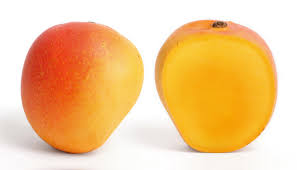

In [7]:
from PIL import Image

Image.open(filelist[125])

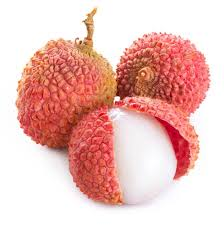

In [8]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread(filelist[9])

img.shape
cv2_imshow(img)


Lets Resize all images to same size

In [18]:
class CustomDataset(Dataset):
  def __init__(self,path,new_size = 226):
    self.filelist = glob.glob(path+'/*.jfif')
    self.new_size = new_size

  def __len__(self):
    return len(self.filelist)

  def __getitem__(self, idx):
    temp_filepath = self.filelist[idx]
    temp_image_tiff = Image.open(temp_filepath)
    temp_image_tiff.seek(0)
    temp_image_tiff = temp_image_tiff.resize((504,504))
    temp_image = np.asarray(temp_image_tiff,dtype=np.float32)
    #temp_image = temp_image.flatten()
    temp_image = temp_image/255
    temp_image = torch.from_numpy(temp_image)
    # img = cv2.imread(self.filelist[idx])
    # img = cv2.resize(img,(self.new_size,self.new_size))
    # img = transforms.ToTensor()(img)
    # #img = transforms.ToTensor()(img).reshape(self.new_size*self.new_size*3)
    return temp_image

In [19]:
Data = CustomDataset(Data_path)
Data[1].shape

torch.Size([504, 504, 3])

**Lets write the first Auto encoder **

In [47]:
class Conv2d_Autoencoder(nn.Module):
    def __init__(self):
        super(Conv2d_Autoencoder, self).__init__()
        latent_dim = 512
 
        # encoder layers
        self.enc1 = nn.Conv2d(3,16,kernel_size=3,stride=3)
        self.enc2 = nn.Conv2d(16,32,kernel_size=3,stride=3)
        self.enc3 = nn.Conv2d(32,64,kernel_size=2,stride=3)
        self.pool = nn.MaxPool2d(2,2)
        self.FC1 = nn.Linear(1600,latent_dim)
        
        # decoder layers
        self.FC2 = nn.Linear(latent_dim,1600)
        self.dec1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=3)  
        self.dec2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=3)
        self.dec3 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=3)
        self.unpool = nn.MaxUnpool2d(2,2)

 
    def forward(self, x):
        # encode
        x = F.relu(self.enc1(x)) # output will be 168x168x16
        x = self.pool(x) #output will be 84x84x16
        x = F.relu(self.enc2(x)) #output will be 28x28x32
        x = self.pool(x)   # output will be 14x14x32
        x = F.relu(self.enc3(x)) #output will be 5x5x64 
        x = x.view(-1,1600) # after flattening the size will be 1600
        x = F.relu(self.FC1(x)) # the latent space representation
        
        # decode
        x = F.relu(self.FC2(x)) #size back to 1600
        x = torch.reshape(x,(5,5,64))
        x = F.relu(self.dec1(x)) # ouput will be 14x14x32
        x = self.unpool(x) #output will be 28x28x32
        print(x.shape)
        x = F.relu(self.dec2(x)) # output will be 84x84x16
        x = self.unpool(x) #output will be 168x168x16
        x = F.sigmoid(self.dec3(x)) # output will be 504x504x3
        return x
 

In [48]:
net = Conv2d_Autoencoder()
print(net)
#summary(net,(504,504,3))

Conv2d_Autoencoder(
  (enc1): Conv2d(3, 16, kernel_size=(3, 3), stride=(3, 3))
  (enc2): Conv2d(16, 32, kernel_size=(3, 3), stride=(3, 3))
  (enc3): Conv2d(32, 64, kernel_size=(2, 2), stride=(3, 3))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (FC1): Linear(in_features=1600, out_features=512, bias=True)
  (FC2): Linear(in_features=512, out_features=1600, bias=True)
  (dec1): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(3, 3))
  (dec2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(3, 3))
  (dec3): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(3, 3))
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
)


In [45]:
summary(net,(3,504,504))

RuntimeError: ignored

In [ ]:
train_loader = DataLoader(Data,batch_size=1)

In [ ]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4) 

if torch.cuda.is_available():
    net.cuda()

net.train()

for epoch in tqdm(range(10)) :
    print(epoch)
    for x in tqdm( train_loader):
        optimizer.zero_grad()
        
        
        if torch.cuda.is_available():
            x = x.cuda()
        prediction = net(x)
        print(x.shape)
        print(prediction.shape)
        
        mse_loss = loss_func(prediction, x) # <-- note that i'm using the input as the target
         
        
        mse_loss.backward()
        optimizer.step()
        
    clear_output(wait=True)

0


torch.Size([1, 3, 226, 226])
torch.Size([1, 3, 236, 236])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1, 3, 226, 226])) that is different to the input size (torch.Size([1, 3, 236, 236])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(8,4))

net.cpu()
net.eval()

img = Data[9]

decoded = net(img).data.numpy().reshape(225,225,3)

ax[0].imshow( img.data.numpy().reshape(225,225,3))
ax[1].imshow( decoded)

ax[0].set_title('input')
ax[1].set_title('reconstructed')

plt.show()